<a href="https://colab.research.google.com/github/carlsec/machine_learning/blob/master/Plant_Pathology_2020_FGVC7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3>Plant Pathology 2020 - FGVC7<h3>

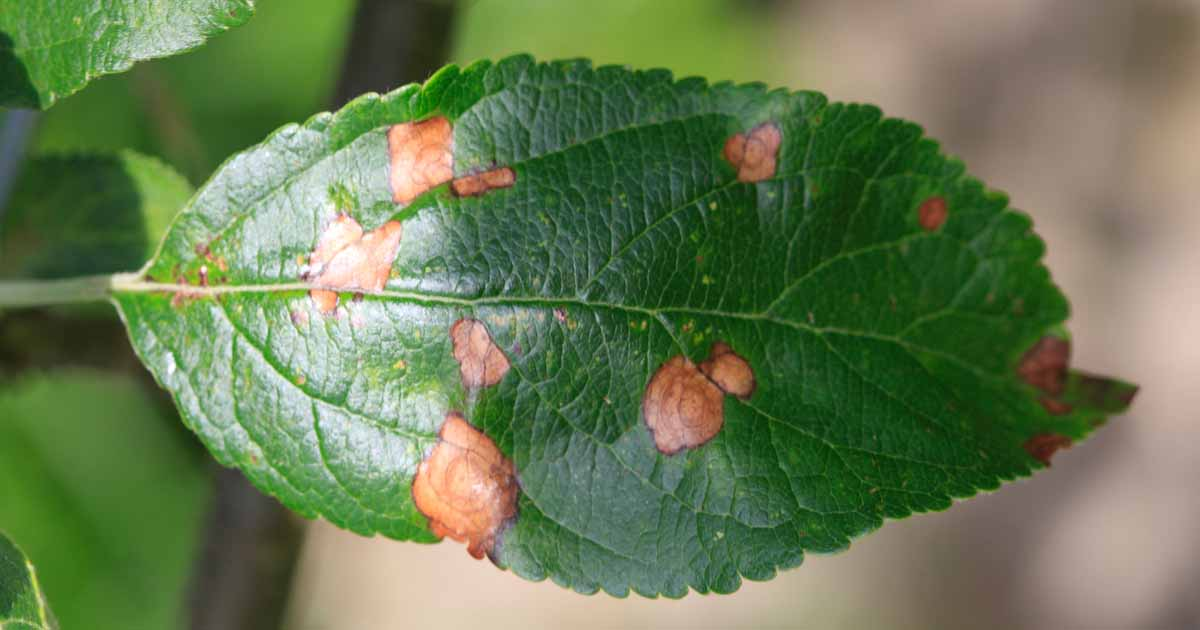

Declaração do Problema

O diagnóstico incorreto de muitas doenças que afetam as safras agrícolas pode levar ao uso indevido de produtos químicos, levando ao surgimento de cepas de patógenos resistentes, aumento dos custos de insumos e mais surtos com perdas econômicas e impactos ambientais significativos. O diagnóstico atual de doenças com base em escotismo humano é demorado e caro e, embora os modelos baseados em visão computacional tenham a promessa de aumentar a eficiência, a grande variação nos sintomas devido à idade dos tecidos infectados, variações genéticas e condições de luz dentro das árvores diminui o precisão de detecção.

Plant Pathology 2020 - FGVC7 e um desafio do kaggle.
https://www.kaggle.com/c/plant-pathology-2020-fgvc7

Objetivo:

1.   Classificar com precisão uma determinada imagem de diferentes doenças ou uma folha saudavel.

2.   Distinguir com precisão entre as doenças.

3.   Lidar com classes raras de doenças.

4.   Abordar percepção de Luz e Profundidade nas imagens.

5.   Incorporar resursos para orientação e identificação.


Vamos usar um modelo de Deep Learning pre-treinado, ou seja esse modelo já e capaz de classificar alguns objetos, vamos apenas ensina-lo a resolver nosso problema.


<h4>Quais são os nossos dados?<h4>

Arquivo ZIP das imagens e dataframes: plant-pathology-2020-fgvc7.zip



In [219]:
import zipfile

path = "/content/drive/MyDrive/plant-pathology-2020-fgvc7.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")
zip_object.close()

In [220]:
!pip install timm

In [221]:
!pip install -U albumentations

In [222]:
import os
import pandas as pd
import numpy as np
import time
import cv2
import PIL.Image
import random
import plotly.express as px
from collections import defaultdict
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms,models,datasets

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR 
#from warmup_scheduler import GradualWarmupScheduler
import albumentations as A
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import roc_auc_score
import seaborn as sns
from pylab import rcParams
import timm
from sklearn.utils import shuffle
from warnings import filterwarnings
filterwarnings("ignore")

device = torch.device('cuda')

In [223]:
params = {
    'image_size': 256,
    'batch_size': 32,
    'model': 'resnet200d',
    'output_dim':4,
    'num_workers': 4,
    'epochs': 5,
    "device": 'cuda'
}

<h3> Importandos os DataFrames de Treino e Teste <h3>

In [224]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Colunas

- **image_id** - nome das imagens
- **healthy** - planta saudavel
- **multiple_diaseses** - planta com multiplas doenças
- **rust** - Doença Rust
- **scab** - Doença Scap

<h4> Cada imagem tem uma resposta(que chamamos de classe), entre as opções: Se caso a imagem tiver mais de uma doença ela e classificada como multiple_diseases.<h4>

- <h4> O modelo de inteligência artifical vai analisar a imagem e extrair informações para que ela possa predizer se a planta e saudavel ou se ela tem alguma doença. <h4>
- <h4> Pensando de uma maneira simples de entender, no conjunto de treino o modelo analisa a imagem e 'olha' as suas respectivas respostas para aprender, por isso chamamos de 'treino', já no conjunto de teste ele apenas vai predizer a classe da imagem, isso garante que o modelo não 'decore' as imagens do conjunto de treino e tenha um pessimo resultado em novas imagens. Se isso acontecer teremos o temido overfitting.<h4>

Veja mais: https://www.3dimensoes.com.br/post/overfitting-e-underfitting

**Como as redes neurais convolucionais extraem informações das imagens ?**

Veja mais: https://medium.com/data-hackers/uma-introdu%C3%A7%C3%A3o-as-redes-neurais-convolucionais-utilizando-o-keras-41ee8dcc033e

In [225]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [226]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.3+ KB


In [227]:
test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


<h2> Olhando os dados <h2>

- As classes estão balancedas, excluindo a classe de multiplas doenças. Já podemos concluir que ela será a classe mais dificil para classificar.

In [228]:
target_cols = train.iloc[:, 1:].columns.tolist()
target_cols

['healthy', 'multiple_diseases', 'rust', 'scab']

In [229]:
fig = px.parallel_categories(train[["healthy", "scab", "rust", "multiple_diseases"]], color="healthy", color_continuous_scale="sunset",\
                             title="Parallel categories plot of targets")
fig

In [230]:
fig = go.Figure([go.Pie(labels=train.columns[1:],
           values=train.iloc[:, 1:].sum().values)])
fig.update_layout(title_text="Pie chart of targets", template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.show()

In [231]:
train.columns

Index(['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')

<h2> Vamos plotar algumas imagens <h2>

A olho nú podemos obter alguns insights(um padrão, algo relevante) nas imagens. 

- **healthy** - A folha e verde e não há manchas.
- **scap** - Manchas escuras e poucos perceptivas.
- **rust** - Grandes manchas amareladas e bastabte visivel.
- **multiple_diaseses** - A folha está bem danificada.

Chageamos a conclusão que existe um padrão, e podemos obeter bons resultados.
Na parte de avaliação teremos uma explanação melhor de como o modelo se comportou.

In [232]:
def image_viewer(base):
    path = 'images/'
    image_filepaths = base['image_id']
    image_filepaths = image_filepaths.iloc[0:16] + '.jpg'
    figure, ax = plt.subplots(nrows=4, ncols=4, figsize=(18, 10))
    for i, image_file in enumerate(image_filepaths):
        image = os.path.join(path, image_file)
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = 'Healthy' if base['healthy'][i] == 1 else ('Multiple Diseases' if base['multiple_diseases'][i] == 1 else ('Rust' if base['rust'][i] == 1 else 'Scab'))
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(label, color='green')
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

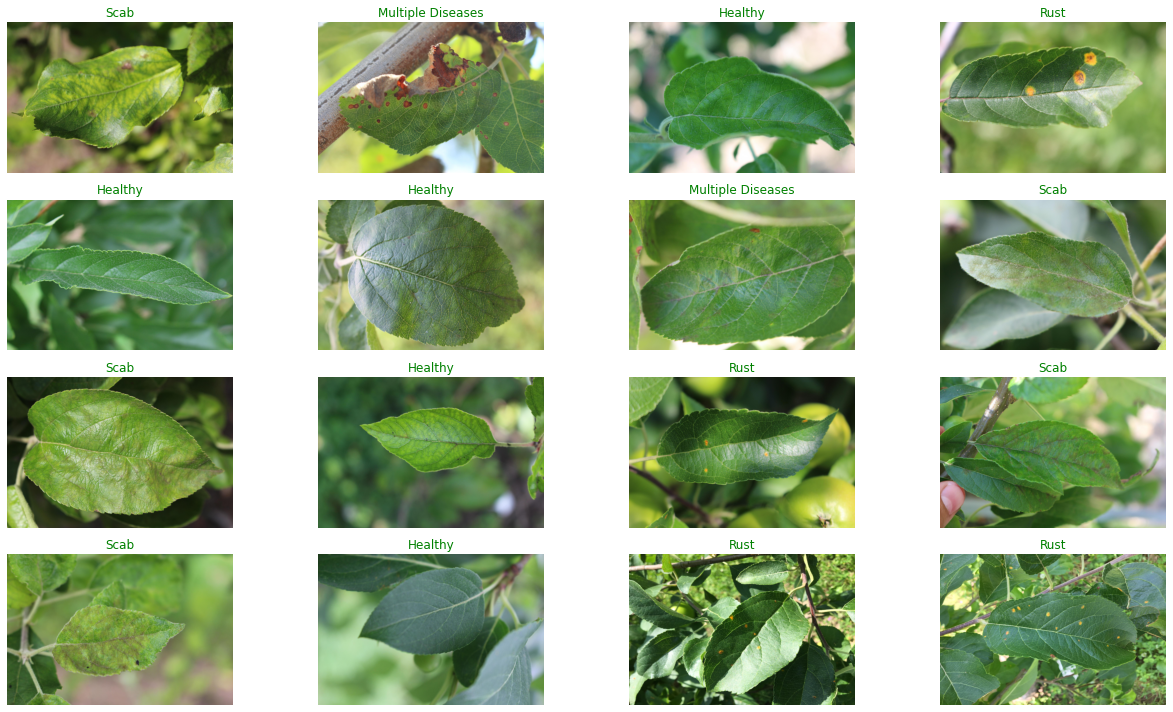

In [233]:
image_viewer(train)

<h2>Modelagem<h2>

Preparando os dados para entrada, criando uma classe para o modelo e as funções de treino, validacão.

In [268]:
class PlantDataset(Dataset):
  def __init__(self, base, mode, aug=None):
    self.base = base
    self.mode = mode
    self.aug = aug
    self.labels = base[target_cols].values if self.mode != 'test' else None

  def __len__(self):
    return len(self.base['image_id'])

  def __getitem__(self, idx):
      image_path = self.base['image_id'][idx]
      image = cv2.imread('/content/images/'+image_path+'.jpg')
      image = np.array(image)

      if self.aug is not None:
          image = self.aug(image=image)["image"]

      if self.mode == 'test':
           return torch.tensor(image/255).permute(2,0,1)
      else:
           label = self.labels[idx]
           return torch.tensor(image/255).permute(2,0,1), torch.tensor(label)

In [236]:
train_transform = A.Compose(
    [   A.Resize(256,256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ])

val_transform = A.Compose(
    [   A.Resize(256,256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ])

In [237]:
class PlatModel(nn.Module):
  def __init__(self, model_name=params['model'], out_dim=params['output_dim'], pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        for param in self.model.parameters():
            param.require_grad = False # Congelandos os peses do modelo Treinado
        n_features = self.model.fc.in_features # Recebe a quantidade Features de saida da ultima camada do modelo
        self.model.global_pool = nn.Identity() # nn.Identity () é um operador de identidade de espaço reservado.
        self.model.fc = nn.Identity() # nn.Identity () é um operador de identidade de espaço reservado.
        self.pooling = nn.AdaptiveAvgPool2d(1) 
        self.fc = nn.Linear(n_features, out_dim)
        self.softmax = nn.Softmax()

  def forward(self, x):
        bs = x.size(0)
        features = self.model(x)
        pooled_features = self.pooling(features).view(bs, -1)
        output = self.fc(pooled_features)
        return self.softmax(output)

In [238]:
model = PlatModel(out_dim=params['output_dim'], pretrained=True)
model = model.to(params["device"])

train_shuffle = shuffle(train)

val = train_shuffle.iloc[:300].reset_index(drop=True)
train_f = train_shuffle.iloc[300:].reset_index(drop=True)

criterion = nn.CrossEntropyLoss().to(params["device"])
optimizer = optim.Adam(model.parameters(), lr=0.0001)

dataset_train = PlantDataset(train_f, 'train', aug=train_transform)
dataset_valid = PlantDataset(val, 'train', aug=val_transform)

train_loader = DataLoader(dataset_train, batch_size=params['batch_size'], shuffle=True)
valid_loader = DataLoader(dataset_valid, batch_size=params['batch_size'], shuffle=False)

In [240]:
!pip install torch_summary
from torchsummary import summary
summary(model, torch.zeros(1,3,256,256));

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 2048, 8, 8]          --
|    └─Sequential: 2-1                   [-1, 64, 128, 128]        --
|    |    └─Conv2d: 3-1                  [-1, 32, 128, 128]        864
|    |    └─BatchNorm2d: 3-2             [-1, 32, 128, 128]        64
|    |    └─ReLU: 3-3                    [-1, 32, 128, 128]        --
|    |    └─Conv2d: 3-4                  [-1, 32, 128, 128]        9,216
|    |    └─BatchNorm2d: 3-5             [-1, 32, 128, 128]        64
|    |    └─ReLU: 3-6                    [-1, 32, 128, 128]        --
|    |    └─Conv2d: 3-7                  [-1, 64, 128, 128]        18,432
|    └─BatchNorm2d: 2-2                  [-1, 64, 128, 128]        128
|    └─ReLU: 2-3                         [-1, 64, 128, 128]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 64, 64]          --
|    └─Sequential: 2-5                   [-1, 256, 64, 64]         --
|    |

In [241]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [242]:
def calculate_accuracy(output, target):
    output = torch.argmax(output, dim=1)
    return accuracy_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

In [243]:
def train_model(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True).float()
        target = target.to(params["device"], non_blocking=True).float()
        target = torch.argmax(target, dim=1)
        output = model(images)
        loss = criterion(output, target)
        accuracy = calculate_accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description("Epoch: {epoch}. Train. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))

In [244]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"]).float()
            target = target.to(params["device"]).float()
            target = torch.argmax(target, 1)
            output = model(images)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)
            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

In [245]:
for epoch in range(1, params['epochs'] + 1):
    train_model(train_loader, model, criterion, optimizer, epoch, params)
    validate(valid_loader, model, criterion, epoch, params)

Epoch: 1. Train. Loss: 1.192 | Accuracy: 0.637: 100%|██████████| 48/48 [01:47<00:00,  2.24s/it]
Epoch: 1. Validation. Loss: 1.361 | Accuracy: 0.299: 100%|██████████| 10/10 [00:12<00:00,  1.27s/it]
Epoch: 2. Train. Loss: 0.840 | Accuracy: 0.911: 100%|██████████| 48/48 [01:47<00:00,  2.24s/it]
Epoch: 2. Validation. Loss: 0.854 | Accuracy: 0.897: 100%|██████████| 10/10 [00:12<00:00,  1.27s/it]
Epoch: 3. Train. Loss: 0.807 | Accuracy: 0.940: 100%|██████████| 48/48 [01:47<00:00,  2.24s/it]
Epoch: 3. Validation. Loss: 0.834 | Accuracy: 0.909: 100%|██████████| 10/10 [00:13<00:00,  1.32s/it]
Epoch: 4. Train. Loss: 0.802 | Accuracy: 0.942: 100%|██████████| 48/48 [01:47<00:00,  2.23s/it]
Epoch: 4. Validation. Loss: 0.831 | Accuracy: 0.909: 100%|██████████| 10/10 [00:12<00:00,  1.27s/it]
Epoch: 5. Train. Loss: 0.797 | Accuracy: 0.947: 100%|██████████| 48/48 [01:47<00:00,  2.25s/it]
Epoch: 5. Validation. Loss: 0.839 | Accuracy: 0.906: 100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


In [247]:
def preds(x, model):
    model.eval()
    prediction = model(x)
    return prediction

In [259]:
test_loader = DataLoader(dataset_valid, batch_size=1, shuffle=False)

target_label = {0: 'Healthy', 1: 'multiple_diseases', 2: 'Rust', 3: 'Scap'}

true_labels = []
pred_labels = []

with torch.no_grad():
  for i, batch in enumerate(test_loader):
    x, y = batch
    y = target_label[int(torch.argmax(y, 1))]
    p = preds(x.cuda(), model)
    p = target_label[int(torch.argmax(p, 1))]
    true_labels.append(y)
    pred_labels.append(p)

In [246]:
sample_submission = pd.read_csv("/content/sample_submission.csv")
sample_submission

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25
...,...,...,...,...,...
1816,Test_1816,0.25,0.25,0.25,0.25
1817,Test_1817,0.25,0.25,0.25,0.25
1818,Test_1818,0.25,0.25,0.25,0.25
1819,Test_1819,0.25,0.25,0.25,0.25


<h2>Avaliação de precisão do modelo.<h2>

In [260]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, pred_labels))

                   precision    recall  f1-score   support

          Healthy       0.90      0.95      0.92        94
             Rust       0.95      0.98      0.96       107
             Scap       0.84      0.93      0.88        82
multiple_diseases       0.00      0.00      0.00        17

         accuracy                           0.90       300
        macro avg       0.67      0.71      0.69       300
     weighted avg       0.85      0.90      0.87       300



- Como já mencionado nosso conjunto e desbalanceado, e como previsto a classe multiple_diseases teve um pessimo resultado, precisamos entender o quão grave isso pode ser.. Por exemplo será que foi predito uma folha doente como saudavel ?

- A matriz de confusão pode ajudar a avaliar essa questão, a classe 0 são as folhas saudaveis, ele acertou 89 folhas e preveu 5 folhas incorretas como sendo da classe 2. 


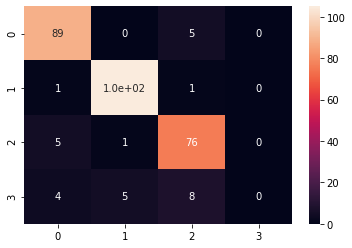

In [262]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(true_labels, pred_labels), annot=True)

<h3> Novas previsões - Conjunto de teste para enviar no desafio do Kaggle <h3>

In [270]:
dataset_test = PlantDataset(test, 'test', aug=val_transform)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=False)

In [271]:
with torch.no_grad():
  for i, batch in enumerate(test_loader):
    x = batch
    p = preds(x.cuda(), model)
    p = p.reshape(p.shape[1])
    sample_submission.iloc[i, 1:] = p.to('cpu').detach().numpy()

In [273]:
sample_submission

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.000079,0.000074,0.999653,0.000193
1,Test_1,0.000399,0.000120,0.999319,0.000162
2,Test_2,0.000121,0.000116,0.000110,0.999653
3,Test_3,0.999940,0.000004,0.000040,0.000016
4,Test_4,0.000025,0.000014,0.999952,0.000010
...,...,...,...,...,...
1816,Test_1816,0.000011,0.000005,0.999980,0.000005
1817,Test_1817,0.021061,0.002581,0.025244,0.951114
1818,Test_1818,0.000483,0.000120,0.999191,0.000206
1819,Test_1819,0.997933,0.000223,0.000659,0.001185


In [274]:
sample_submission.to_csv('submission.csv', index = False)

Conclusão: Score de 90%, o mesmo valor obtido na validação. 

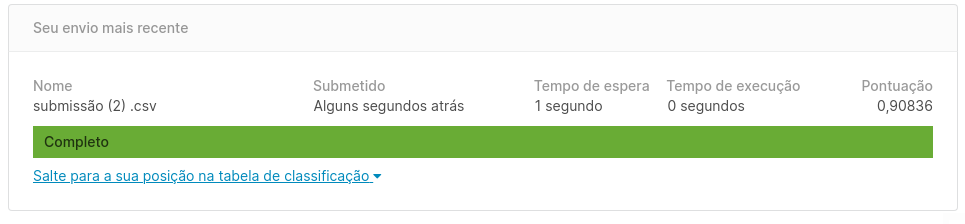